This project uses a subset (1,000 samples) of the multilingual CCNews dataset from Hugging Face.
The goal is to explore underlying semantic structures within the news articles using BERTopic, a transformer-based topic modeling method.

In [1]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("stanford-oval/ccnews", split="train", streaming=True)

# first 1000 data
small_data = []
for i, item in enumerate(dataset):
    if i >= 1000:
        break
    small_data.append(item)

df = pd.DataFrame(small_data)
print(df.head())

Resolving data files:   0%|          | 0/479 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/479 [00:00<?, ?it/s]

                                       requested_url  \
0  http://www.coventrytelegraph.net/news/its-not-...   
1  http://www.coventrytelegraph.net/news/coventry...   
2  http://www.coventrytelegraph.net/news/buying-d...   
3  http://www.coventrytelegraph.net/sport/footbal...   
4  http://www.manilatimes.net/pgaa-tops-sonny-ty-...   

                                          plain_text published_date  \
0  Even if you missed out on snapping-up a new pl...     2016-10-18   
1  The daughter of a former police inspector who ...     2016-10-18   
2  Watch: How alcohol can cause cancer  Buying yo...     2016-10-18   
3  November is fast approaching - and that means ...     2016-10-18   
4  The Philippine Gymnastics and Athletics Academ...     2016-10-18   

                                               title tags     categories  \
0  It's not just AA plastic £5 notes that are val...                News   
1  'One of the good guys' - tribute to rugby-lovi...       Coventry News   
2  Why b

In [2]:
df.info()
df.describe(include='all')
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   requested_url   1000 non-null   object 
 1   plain_text      1000 non-null   object 
 2   published_date  1000 non-null   object 
 3   title           1000 non-null   object 
 4   tags            1000 non-null   object 
 5   categories      1000 non-null   object 
 6   author          787 non-null    object 
 7   sitename        1000 non-null   object 
 8   image_url       877 non-null    object 
 9   language        1000 non-null   object 
 10  language_score  1000 non-null   float64
 11  responded_url   1000 non-null   object 
 12  publisher       1000 non-null   object 
 13  warc_path       1000 non-null   object 
 14  crawl_date      1000 non-null   object 
dtypes: float64(1), object(14)
memory usage: 117.3+ KB


author            213
image_url         123
requested_url       0
plain_text          0
published_date      0
title               0
tags                0
categories          0
sitename            0
language            0
language_score      0
responded_url       0
publisher           0
warc_path           0
crawl_date          0
dtype: int64

<Axes: xlabel='sitename'>

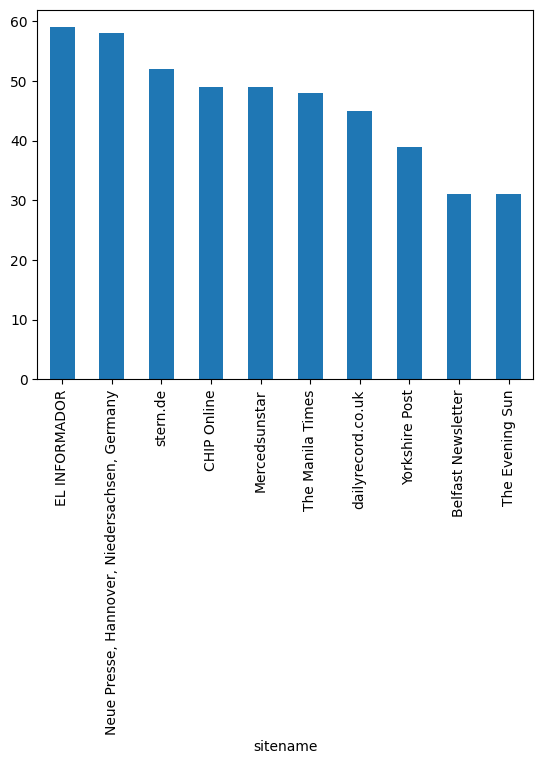

In [3]:
df['sitename'].value_counts().head(10).plot(kind='bar')

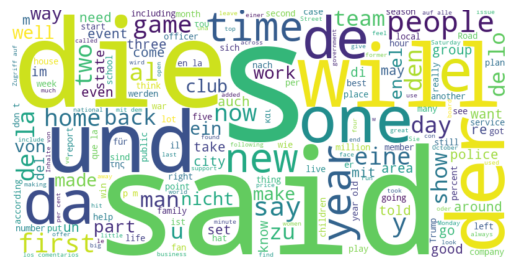

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Merged text
text = " ".join(df['plain_text'].dropna().tolist())

# generated word cloud（remove stopword）
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white', 
                      stopwords=STOPWORDS).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

To prepare the text for topic modeling, all news bodies were lowercased, punctuation removed, and both standard and domain-specific stopwords (e.g., “said”, “would”, “year”) were excluded.
This preprocessing ensured that the resulting embeddings focus on semantic content rather than stylistic artifacts.

In [7]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# List of basic stop words (English)
stop_words = set(stopwords.words('english'))

# Custom extensions: high-frequency but uninformative words for news corpus
custom_stopwords = {
    "said", "would", "one", "new", "also", "people", "time", "year",
    "could", "may", "like", "make", "two", "first", "last", "us",
    "mr", "ms", "say", "news", "today", "week"
}

# Merge stop words
stop_words = stop_words.union(custom_stopwords)

def clean_text(text):
    # 1. lowercase
    text = text.lower()
    # 2. Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Remove the stop words
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Applying the cleaning function
df_en = df[df['language'] == 'en']
df_en['clean_text'] = df_en['plain_text'].apply(lambda x: clean_text(str(x)))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tiantian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/vk/wh57zgsj4dgdmfrh2qvbyyy80000gn/T/ipykernel_46814/4018421050.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['clean_text'] = df_en['plain_text'].apply(lambda x: clean_text(str(x)))


After embedding the text with Sentence-BERT (all-MiniLM-L6-v2) and clustering with UMAP + HDBSCAN,
BERTopic identified 9 coherent topics, corresponding to distinct semantic domains within the news dataset.

In [8]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP

umap_model = UMAP(random_state=42)
model = SentenceTransformer("all-MiniLM-L6-v2")

texts = df_en['clean_text'].sample(500, random_state=42)

topic_model = BERTopic(
    embedding_model=model,
    umap_model=umap_model,
    language="english",
    min_topic_size=10
)

topics, probs = topic_model.fit_transform(texts)
topic_info = topic_model.get_topic_info()
topic_info.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,143,-1_city_years_club_get,"[city, years, club, get, take, school, says, p...",[supporterled takeover approach coventry city ...
1,0,99,0_million_per_years_work,"[million, per, years, work, company, percent, ...",[state utilities regulators grappled simple qu...
2,1,89,1_police_man_officers_court,"[police, man, officers, court, officer, found,...",[rugby league player arrested incident left po...
3,2,37,2_game_celtic_team_players,"[game, celtic, team, players, league, rangers,...",[tartan army hit hotline voice anger gordon st...
4,3,30,3_music_show_album_pm,"[music, show, album, pm, band, songs, st, tour...",[theres choice going put show announced chris ...
5,4,24,4_restaurant_food_private_beer,"[restaurant, food, private, beer, dining, room...",[chad forsberg growing food best restaurants t...
6,5,22,5_game_texans_cavaliers_play,"[game, texans, cavaliers, play, wizards, team,...",[best bets weekends college nfl games havent c...
7,6,17,6_russian_pr_aleppo_disaster,"[russian, pr, aleppo, disaster, president, typ...",[theresa condemned vladimir putins aggression ...
8,7,16,7_trump_clinton_donald_campaign,"[trump, clinton, donald, campaign, republican,...",[democratic political operatives longer workin...
9,8,13,8_voters_ohio_trump_election,"[voters, ohio, trump, election, ballot, journa...",[columbus ohio ap nonpartisan voting rights gr...


The visualization shows the top-ranked words for each discovered topic.
Topics are semantically well-separated — from entertainment and sports to politics and international conflicts.
Political discourse (Topic 7–8) appears dominant, consistent with the 2016–2017 global news timeline.
Lifestyle and sports topics (Topic 4–5) reflect everyday coverage patterns typical of online media.

In [ ]:
topic_model.visualize_barchart(top_n_topics=10)

BERTopic identified ten distinct themes within the English news dataset, including crime and law, sports, entertainment, food and dining, politics, and business.
The clustering results show clear topic separation, indicating that the corpus naturally organizes around major news domains.

In [14]:
import ollama
import json

# Define the possible topic labels for news classification.
# The model must choose exactly ONE of these labels.
LABELS = [
    "Sports", "Politics", "Entertainment", "Food&Drink",
    "Crime&Law", "Elections", "Other"
]

# The system prompt defines the model's role and rules.
# It instructs the model to behave as a strict classifier,
# and to respond ONLY in a structured JSON format.
SYSTEM = (
    "You are a precise news section classifier. "
    "Given title and body, return one label from the allowed set. "
    "Answer ONLY as strict JSON: {\"label\": <one of LABELS>, \"rationale\": <short reason>}."
)

# This is the user prompt template.
# It dynamically inserts the labels, title, and body of each news article.
# The prompt explicitly restricts the model output to one label and one rationale.
USER_TMPL = """Allowed labels: {labels}

Title: {title}
Body: {body}

Rules:
- Pick exactly ONE label from the allowed set.
- Keep rationale under 20 words.
Return ONLY JSON, no extra text.
"""

# ------------------------------
# Function: classify_one()
# ------------------------------
# This function sends one news item (title + body) to the LLM for classification.
# It constructs a prompt, calls the Ollama API, parses the response,
# and returns a tuple (label, rationale).
def classify_one(title, body, model="qwen2.5:7b"):
    # Fill in the user template with the article content.
    # Limit title/body length to prevent overly long inputs.
    msg = USER_TMPL.format(labels=", ".join(LABELS), title=title[:180], body=body[:1000])
    
    # Combine system and user messages into one complete prompt.
    full_prompt = SYSTEM + "\n\n" + msg
    
    try:
        # Send the request to the local Ollama API.
        # The model generates a classification label and a brief rationale.
        response = ollama.chat(
            model=model,
            messages=[{"role": "user", "content": full_prompt}]
        )

        # Extract the model's raw response text.
        text = response["message"]["content"].strip()

        # Try to parse the model's JSON output.
        data = json.loads(text)

        # Safely extract the "label" and "rationale" fields.
        label = data.get("label", "Other")
        rationale = data.get("rationale", "")

    # Handle JSON format errors (if model output isn't valid JSON).
    except json.JSONDecodeError:
        label, rationale = "Other", "parse_error"

    # Handle all other runtime errors (network, timeout, etc.).
    except Exception as e:
        label, rationale = "Other", f"error: {e}"

    # Return both classification label and reasoning.
    return label, rationale

In [24]:
# Make sure the sample exists (e.g., 200 random entries).
sample = df.sample(200, random_state=42).copy()

# Create an empty list first
labels, reasons = [], []

# Run classification 
for _, row in sample.iterrows():
    label, why = classify_one(
        row.get("title", ""), 
        row.get("plain_text", "")
    )
    labels.append(label)
    reasons.append(why)

# Defensive patching (to avoid inconsistent lengths)
while len(labels) < len(sample):
    labels.append("Other")
    reasons.append("missing")

sample["llm_label"] = labels
sample["llm_rationale"] = reasons

In [40]:
#Change previous function call to use llama3.2:3b:
label, why = classify_one(
    df_llm.iloc[0]["title"],
    df_llm.iloc[0]["plain_text"],
    model="llama3.2:3b"  
)
print(label, why)

Business/Economy German real estate market trend analysis and data on rising rents


In [47]:
# Sampling + Initialization
sample = df_llm.sample(50, random_state=42).copy()
labels, rationales = [], []

# Run reasoning (faster)
for _, row in sample.iterrows():
    label, why = classify_one(row["title"], row["plain_text"], model="llama3.2:3b")
    labels.append(label)
    rationales.append(why)

# Write the results back to the sample set
sample["llm_label"] = labels
sample["llm_rationale"] = rationales

# Export (50 articles only)
sample.to_csv("llm_sampled_classified.csv", index=False)

In [ ]:
# Filter English + text length 80~1200 words to avoid misjudgment of very short/long text.
mask = (df_llm['language'].fillna('en').str.lower().str.startswith('en')) & \
        (df_llm['plain_text'].astype(str).str.len().between(80, 1200))
df_use = df_llm[mask].copy()

# If too few, relax the range to 40 to 1600.
if len(df_use) < 60:
    mask = (df_llm['language'].fillna('en').str.lower().str.startswith('en')) & \
            (df_llm['plain_text'].astype(str).str.len().between(40, 1600))
    df_use = df_llm[mask].copy()

print(len(df_use))

63


In [ ]:
LABELS = [
    "Sports", "Politics", "Entertainment", "Food&Drink",
    "Crime&Law", "Elections", "Business/Economy", "Technology", "Other"
]

# Synonyms → Standard Label Mapping
CANON_MAP = {
    "sport": "Sports", "sports": "Sports",
    "politic": "Politics", "politics": "Politics",
    "entertainment": "Entertainment", "culture": "Entertainment",
    "food": "Food&Drink", "drink": "Food&Drink", "dining": "Food&Drink", "restaurant": "Food&Drink",
    "crime": "Crime&Law", "law": "Crime&Law", "court": "Crime&Law",
    "election": "Elections", "elections": "Elections", "vote": "Elections",
    "business": "Business/Economy", "economy": "Business/Economy", "economic": "Business/Economy", "finance": "Business/Economy", "market": "Business/Economy",
    "tech": "Technology", "technology": "Technology", "ai": "Technology", "software": "Technology", "hardware": "Technology",
}

def canonicalize(label: str) -> str:
    if not label:
        return "Other"
    low = label.strip().lower()
    # perfect match
    for k, v in CANON_MAP.items():
        if low == k:
            return v
    # Include word matching (more robust)
    for k, v in CANON_MAP.items():
        if k in low:
            return v
    # Already a standard label
    for L in LABELS:
        if low == L.lower():
            return L
    return "Other"

In [45]:
import ollama, json, re

SYSTEM = (
    "You are a precise news section classifier.\n"
    "You MUST answer ONLY with a valid JSON object in the format:\n"
    "{\"label\": <one of LABELS>, \"rationale\": <short reason>}.\n"
    "Do not add extra text, no markdown, no code fences."
)

FEWSHOT = [
    {
        "role": "user",
        "content": (
            "Allowed labels: Sports, Politics, Entertainment, Food&Drink, "
            "Crime&Law, Elections, Business/Economy, Technology, Other\n\n"
            "Title: Team wins in NBA opening game\n"
            "Body: The Lakers defeated the Warriors in the season opener...\n"
            "Rules: Pick exactly ONE label."
        )
    },
    {"role": "assistant", "content": "{\"label\":\"Sports\",\"rationale\":\"Basketball game result\"}"},
    {
        "role": "user",
        "content": (
            "Allowed labels: Sports, Politics, Entertainment, Food&Drink, "
            "Crime&Law, Elections, Business/Economy, Technology, Other\n\n"
            "Title: Apple unveils new chip\n"
            "Body: Apple introduced a new processor aimed at improving AI...\n"
            "Rules: Pick exactly ONE label."
        )
    },
    {"role": "assistant", "content": "{\"label\":\"Technology\",\"rationale\":\"Tech product announcement\"}"},
]

USER_TMPL = """Allowed labels: {labels}

Title: {title}
Body: {body}

Rules:
- Pick exactly ONE label from the allowed set.
- Keep rationale under 20 words.
Return ONLY JSON, no extra text.
"""

JSON_RE = re.compile(r"\{.*\}", re.S)  # 尽量抓到第一个 JSON 对象

def classify_one(title, body, model="llama3.2:3b"):
    prompt = USER_TMPL.format(labels=", ".join(LABELS),
                              title=(title or "")[:200],
                              body=(body or "")[:1200])
    messages = [{"role": "system", "content": SYSTEM}] + FEWSHOT + [{"role":"user","content": prompt}]
    try:
        resp = ollama.chat(model=model, messages=messages, options={"temperature": 0})
        text = resp["message"]["content"].strip()

        # 不是纯 JSON 时，尽量提取 JSON 段
        m = JSON_RE.search(text)
        if m:
            text = m.group(0)

        data = json.loads(text)
        raw_label = data.get("label", "Other")
        label = canonicalize(raw_label)  # 映射到标准标签
        why = data.get("rationale", "")
        if label not in LABELS:
            label = "Other"
        return label, why
    except Exception as e:
        return "Other", f"error: {e}"

In [38]:
sample = df_use.sample(30, random_state=42).copy()

labels, whys = [], []
for _, row in sample.iterrows():
    label, why = classify_one(row.get("title",""), row.get("plain_text",""), model="llama3.2:3b")
    labels.append(label); whys.append(why)

sample["llm_label"] = labels
sample["llm_rationale"] = whys

print(sample["llm_label"].value_counts(normalize=True).mul(100).round(1))
sample.head(3)[["title","llm_label","llm_rationale"]]

llm_label
Crime&Law           43.3
Sports              20.0
Business/Economy    10.0
Entertainment       10.0
Other                6.7
Politics             6.7
Food&Drink           3.3
Name: proportion, dtype: float64


,title,llm_label,llm_rationale
195,Musselburgh carer on trial for client fraud,Crime&Law,Carer accused of client fraud
188,BRIEF-Crispr Therapeutics AG shares open at $1...,Business/Economy,Financial news and market data report
1,TRICO to host open house Oct. 20,Other,Local business event with community focus on d...


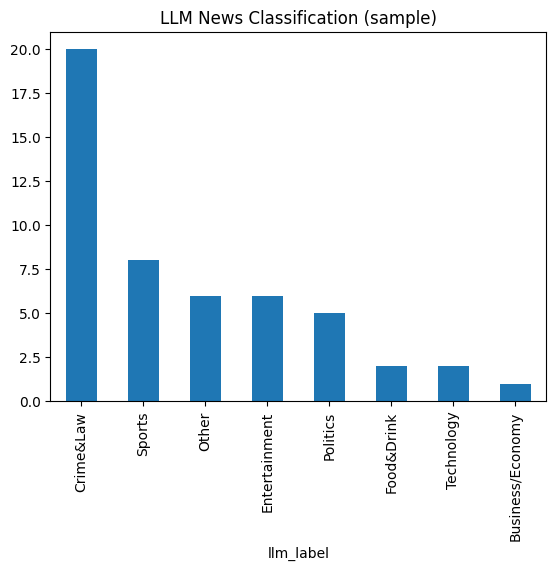

In [46]:
import matplotlib.pyplot as plt
sample["llm_label"].value_counts().plot(kind="bar")
plt.title("LLM News Classification (sample)")
plt.show()

Both BERTopic and LLM-based classification identified overlapping semantic structures in the news dataset.
BERTopic uncovered topic clusters around sports events, law enforcement, music & entertainment, and political campaigns.
Correspondingly, the LLM classifier labeled most texts as Crime&Law and Sports, followed by Business/Economy and Politics.
This convergence indicates that unsupervised topic modeling and LLM-driven classification capture consistent thematic trends — validating the coherence of underlying news categories.